In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import resource
import sys
import gc
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.data as ds
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from functools import partial
# uncomment for debugging layers
# tf.config.run_functions_eagerly(True) 

!nvidia-smi -L

@tf.function
def image_float_to_int(image): 
    return tf.image.convert_image_dtype(image, tf.uint8)


@tf.function
def load_image(file_path, img_size=[306, 306]):
    raw = tf.io.read_file(file_path)
    return tf.image.decode_jpeg(raw, channels=3)


@tf.function
def random_crop(image, size=128):
    '''
    crop a random box out of the image
    :param image: image tensor to be modified
    :param size: int. The pixel size of the cropped box
    '''
    s = tf.shape(image)
    w = s[0]
    h = s[1]
    c = s[2]
    dh = size
    dw = size
    dx = tf.random.uniform([1], minval=0, maxval=w-dw, dtype=tf.dtypes.int32, seed=None, name=None)[0]
    dy = tf.random.uniform([1], minval=0, maxval=h-dh, dtype=tf.dtypes.int32, seed=None, name=None)[0]
    offset_height = dy
    target_height = dh
    offset_width = dx
    target_width = dw
    image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, target_height, target_width)
    return image


@tf.function
def box_delete(image, size=32, l=0.9):
    '''
    :param image: image tensor to be modified
    :param strength: int. The pixel size of the deleted box
    '''
    s = tf.shape(image)
    w = s[0]
    h = s[1]
    c = s[2]
    # compute size and position of mask
    dh = size
    dw = size
    dx = tf.random.uniform([1], minval=0, maxval=w-dw, dtype=tf.dtypes.int32, seed=None, name=None)[0]
    dy = tf.random.uniform([1], minval=0, maxval=h-dh, dtype=tf.dtypes.int32, seed=None, name=None)[0]
    # prepare indices
    xs = tf.range(start=dx, limit=dx+dw)
    ys = tf.range(start=dy, limit=dy+dh)
    X, Y = tf.meshgrid(ys, xs)
    X = tf.reshape(X, [-1, 1])
    Y = tf.reshape(Y, [-1, 1])
    mask_indices = tf.concat([Y, X], axis=-1)
    mask_indices = tf.reshape(mask_indices, [-1, 2])
    # prepare image patch
    updates_hard = tf.random.uniform([dw*dh, c], minval=0, maxval=1, dtype=tf.dtypes.float32) # hard noise
    updates_soft = tf.random.uniform([dw*dh, c], minval=0, maxval=0.1, dtype=tf.dtypes.float32) # soft noise
    updates_black = tf.zeros([dw*dh, c], dtype=tf.dtypes.float32) # black (zeros)
    # overwrite image with patch
    modified_image = tf.tensor_scatter_nd_update(image, mask_indices, updates_black, name=None) # replace with noise
    lam = tf.constant(l, dtype=tf.dtypes.float32)
    one_minus_lam = tf.constant(1-l, dtype=tf.dtypes.float32)
    updates_weights = tf.ones([dw*dh, c], dtype=tf.dtypes.float32) * one_minus_lam
    weights = tf.tensor_scatter_nd_update(tf.ones_like(image, dtype=tf.dtypes.float32) * lam, mask_indices, updates_weights, name=None)
    weights = tf.reshape(weights, [-1,])
#     modified_image = tf.tensor_scatter_nd_add(image, mask_indices, updates_black, name=None) # add noise
    return modified_image, image, weights

@tf.function
def add_noise(image, strength=0.1):
    '''
    :param image: image tensor to be modified
    :param strength: float, [0,1]. The amount of noise to add
    '''
    s = tf.shape(image)
    w = s[0]
    h = s[1]
    c = s[2]
    # prepare noise
    noise = tf.random.uniform([w, h, c], minval=0, maxval=strength, dtype=tf.dtypes.float32) # soft noise
    # add noise
    modified_image = image + noise
    weights = tf.ones_like(image, dtype=tf.dtypes.float32)
    weights = tf.reshape(weights, [-1,])
    return modified_image, image, weights

def flatten_labels(modified_image, image, weights):
    flattened = tf.reshape(image, [-1,1])
    return modified_image, flattened, weights

## visualize the dataset
def visualize_dst(dst):
    print_images = dst.take(9)
    plt.figure(figsize=(10, 10))
    for i, images, weights in enumerate(print_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images.numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")
    return dst


def visualize_training(dst):
    dst = dst.take(3)
    plt.figure(figsize=(6, 10))
    i = 0
    for image, gt, weights in dst:
        image = tf.image.convert_image_dtype(image, tf.uint8)
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        i+=1
        plt.axis("off")
        gt = tf.image.convert_image_dtype(gt, tf.uint8)
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(gt.numpy().astype("uint8"))
        i+=1
        plt.axis("off")
        #plt.title(class_names[labels[i]])
    return dst

GPU 0: Tesla T4 (UUID: GPU-7a46ceb4-f5f5-e73e-d0e7-f813d105f536)


Now that we have an input pipeline and we can see and verify our data, lets create a model.
Given image A and its distorted version D(A), compute a recovered version R(D(A)) which is as close as possible to the original A:
argmin_W{|A-R_W(D(A))|^2}

We will go with a unet model which will encode the features to each pixel. We will then train the DNN on the above task.
Thus for an input x the model will output:
f(x)=En(x) - the pixel wise features
R(x)=De(x) - the recovered picture

In [2]:
# inspect graphs to find if memory leak is here
tf.executing_eagerly()


True

In [3]:
class ConvBlock(keras.layers.Layer):
    '''
    convolution block for unet with optional max pooling
    '''
    def __init__(self, filters, downsample=True, bname='', **kwargs):
        self.filters = filters
        self.bname = bname
        self.downsample = downsample
        super(ConvBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(filters=self.filters, kernel_size=(3,3), strides=(1, 1),
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=bname+"_conv_1")
        self.conv2 = keras.layers.Conv2D(filters=self.filters, kernel_size=(3,3), strides=(1, 1),
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=bname+"_conv_2")
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'bname': self.bname,
            'downsample': self.downsample
        })
        return config
    
    
    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = keras.layers.ReLU(name=self.bname+"_relu_1")(x)
        # stride 2, padding 1, k=3, o=i/2
#         x = keras.layers.ZeroPadding2D(padding=(1, 1), data_format='channels_last', name=self.bname+"_zeroPad")(x) 
        x = self.conv2(x)
        x = keras.layers.ReLU(name=self.bname+"_relu_2")(x)
        p = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', 
                                      name=self.bname+"_maxpool")(x)
        return x, p


class DeConvBlock(keras.layers.Layer):
    '''
    convolution block for unet with optional max pooling
    '''
    def __init__(self, filters, bname='', **kwargs):
        self.filters = filters
        self.bname = bname
        super(DeConvBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2DTranspose(filters=self.filters, kernel_size=(3,3), strides=2,
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=bname+"_deconv")
        self.conv2 = keras.layers.Conv2D(filters=self.filters, kernel_size=(3,3), strides=1,
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=bname+"_conv")
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'bname': self.bname
        })
        return config
    
    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = keras.layers.ReLU(name=self.bname+"_relu_1")(x)
        x = self.conv2(x)
        x = keras.layers.ReLU(name=self.bname+"_relu_2")(x)
        return x

class PaddedBase(keras.layers.Layer):
    '''
    base class for layers involving padding one input to match the other
    '''
    def build(self, input_shape):
        self.shape1 = input_shape[0]
        self.shape2 = input_shape[1]
        dh = self.shape1[1] - self.shape2[1]
        dw = self.shape1[2] - self.shape2[2]
        self.bigger_shape = self.shape1[:3]
        self.smaller_shape = self.shape2[:3]
        self.c1 = self.shape1[3]
        self.c2 = self.shape2[3]
        self.pred = tf.logical_or(tf.math.less(dw, 0), tf.math.less(dh, 0))
        if self.pred:
            dh = - dh
            dw = - dw
            self.bigger_shape = self.shape2[:3]
            self.smaller_shape = self.shape1[:3]
        hmod = tf.math.floormod(dh, 2)
        hdiv = tf.cast(tf.math.divide(dh - hmod, 2), tf.int32)
        wmod = tf.math.floormod(dw, 2)
        wdiv = tf.cast(tf.math.divide(dw - wmod, 2), tf.int32)
        dhup = hdiv
        dhdown = hdiv + hmod
        dwleft = wdiv
        dwright = wdiv + wmod
        padB = tf.constant([0, 0])
        padh = tf.stack([dhup, dhdown], axis=-1)
        padw = tf.stack([dwleft, dwright], axis=-1)
        padC = tf.constant([0, 0])
        self.paddings = tf.stack([padB, padh, padw, padC], axis=0)

class PadToSize(PaddedBase):
    '''
    padding the smaller tensor so the shapes match and return the first
    '''
    @tf.function
    def call(self, inputs):
        tensor_1, tensor_2 = inputs
        tensor_3 =  tf.pad(tensor_1, paddings=self.paddings , mode='CONSTANT', constant_values=0)
        return tensor_3
        
class PaddedConcat(PaddedBase):
    '''
    concats two tensors, padding the smaller tensor so the shapes match
    ''' 
    @tf.function
    def call(self, inputs):
        tensor_1, tensor_2 = inputs
        tensor_3 =  tf.pad(tensor_1, paddings=self.paddings , mode='CONSTANT', constant_values=0)
        out = tf.concat([tensor_3, tensor_2], axis=-1)
        return out

class PaddedAdd(PaddedBase):
    '''
    concats two tensors, padding the smaller tensor so the shapes match
    '''
    @tf.function
    def call(self, inputs):
        tensor_1, tensor_2 = inputs
        tensor_3 =  tf.pad(tensor_1, paddings=self.paddings , mode='CONSTANT', constant_values=0)
        out = tf.math.add(tensor_3, tensor_2)
        return out
    
class CropToShape(keras.layers.Layer):
    '''
    crop input to specified shape
    '''
    def build(self, input_shape):
        shape1 = input_shape[0]
        shape2 = input_shape[1]
        self.h = shape2[1]
        self.w = shape2[2]
    
    @tf.function
    def call(self, inputs):
        return tf.slice(inputs[0], [0, 0, 0, 0], [-1, self.h, self.w, -1])

    
def bridge(x, bridge_features, num=0):
    if len(bridge_features) > 0:
        name = "bridge_layer_"+str(num)
        x = keras.layers.Conv2D(filters=bridge_features[0], kernel_size=(3,3), strides=(1, 1),
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=name+"_conv")(x)
        x = keras.layers.ReLU(name=name+"_relu")(x)
        return bridge(x, bridge_features[1:], num+1)
    else:
        return x
        
    
def Unet(x, bridge_features, encoder_filters_list, decoder_filters_list, skip_connections, level=0):
    tf.debugging.assert_shapes([(encoder_filters_list,('N')),(decoder_filters_list,('N'))],
                               message="encoder and decoder have different length!")
    #encoder
    bname = "encoder_layer_"+str(level)
    xout, p = ConvBlock(encoder_filters_list[0], bname=bname)(x)
    if len(encoder_filters_list) > 1:
        x = Unet(p, bridge_features, encoder_filters_list[1:], 
                 decoder_filters_list[:-1], skip_connections[:-1], level=level+1)
    else:
        x = bridge(p, bridge_features, num=0)
    #decoder
    bname = "decoder_features_"+str(level)
    x = DeConvBlock(decoder_filters_list[-1], bname=bname)(x)
    if skip_connections[-1]==1:
        # skip connection
        print("x:", x)
        print("xout:", xout)
        x = PaddedConcat(name=bname+"_concat")([x, xout])
#         x = PaddedAdd(name=bname+"_add")([x, xout])
    else:
        # no skip connection here so just padd as necessary
        x = PadToSize()([x, xout])
    return x
    

def AutoEncoder(x, bridge_features, encoder_filters_list, decoder_filters_list, level=0):
    tf.debugging.assert_shapes([(encoder_filters_list,('N')),(decoder_filters_list,('N'))],
                               message="encoder and decoder have different length!")
    #encoder
    bname = "encoder_layer_"+str(level)
    xout, p = ConvBlock(encoder_filters_list[0], bname=bname)(x)
    if len(encoder_filters_list) > 1:
        x = AutoEncoder(p, bridge_features, encoder_filters_list[1:], decoder_filters_list[:-1], level=level+1)
    else:
        x = bridge(p, bridge_features, num=0)
    #decoder
    bname = "decoder_features_"+str(level)
    x = DeConvBlock(decoder_filters_list[-1], bname=bname)(x)  
    x = PadToSize()([x, xout])
    return x
        

def get_completion_model(bridge_features, encoder_filters_list, decoder_filters_list, skip_connections,
                         head_filters_list):
    image = keras.layers.Input(shape=[128,128, 3], dtype='float32', name="input_org")
    features = Unet(image, bridge_features, encoder_filters_list, decoder_filters_list, skip_connections)
#     features = AutoEncoder(image, bridge_features, encoder_filters_list, decoder_filters_list)
    kernel_size = (1,1) #(3,3)
    for i, f in enumerate(head_filters_list):
        features_in = features
        features = keras.layers.Conv2D(filters=f, kernel_size=kernel_size, strides=(1, 1),
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros")(features)
        features = keras.layers.ReLU(name="head_conv_"+str(i)+"_conv_out")(features)
    recovered_image = features
    flattened_recovered_image = tf.keras.layers.Reshape([-1,1])(recovered_image)
    return keras.Model(inputs=image, outputs=flattened_recovered_image)

def get_simple_model():
    image = keras.layers.Input(shape=[128,128, 3], dtype='float32', name="input_org")
    features = keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(image)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="valid", data_format='channels_last')
    features = keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="valid", data_format='channels_last')
    features = keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="valid", data_format='channels_last')
    features = keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    tf.keras.layers.UpSampling2D(size=(2, 2), data_format='channels_last', interpolation="nearest")
    features = keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    tf.keras.layers.UpSampling2D(size=(2, 2), data_format='channels_last', interpolation="nearest")
    features = keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    tf.keras.layers.UpSampling2D(size=(2, 2), data_format='channels_last', interpolation="nearest")
    features = keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    features = keras.layers.Conv2D(filters=3, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    features = tf.keras.layers.Reshape([-1,1])(features)
    return keras.Model(inputs=image, outputs=features)

class PixelWiseHuberVisualize(keras.losses.Loss):
    def call(self, img_true, img_pred):
        #img_pred = tf.reshape(tf.convert_to_tensor_v2(img_pred), [-1, 1])
#         img_pred = tf.reshape(img_pred, [-1, 1])
#         img_true = tf.reshape(tf.cast(img_true, img_pred.dtype), [-1, 1])
        # image values are in [0,1] so put delta in the middle
        h = tf.math.squared_difference(img_pred, img_true)
#         h = tf.keras.losses.Huber(delta=0.5, reduction=keras.losses.Reduction.NONE)
#         return h(img_pred, img_true)
        return h


class PixelWiseHuber(keras.losses.Loss):
    @tf.function
    def call(self, img_true, img_pred):
        #img_pred = tf.reshape(tf.convert_to_tensor_v2(img_pred), [-1, 1])
#         img_pred = tf.reshape(img_pred, [-1, 1])
#         img_true = tf.reshape(tf.cast(img_true, img_pred.dtype), [-1, 1])
        # image values are in [0,1] so put delta in the middle
        shape1 = tf.shape(img_pred)
        shape2 = tf.shape(img_true)
#         tf.print("pred shape=", shape1, "original shape=", shape2)
        return tf.keras.losses.Huber(delta=0.5)(img_pred, img_true)

Test the loss function to see that it gives correct values. Test by adding noise to an image and plotting the loss as a function of SNR:

In [4]:
# inspect graphs to find if memory leak is here

In [15]:
@tf.function
def add_gaussian_noise(image, invSNR):
    A = tf.norm(image)
    std = invSNR * A
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=std)
    return tf.math.add(image, noise)


def visualize_loss(dst):
    original = dst.take(1)

    plt.figure(figsize=(10, 10))
    for original in original:
        aug, org, w = original
        #     loss_image = original.map(tf.math.squared_difference)
        org = tf.reshape(org, tf.shape(aug))
        loss_image = keras.losses.huber(aug, org)
        loss_image = tf.image.convert_image_dtype(loss_image, tf.uint8)
        aug = tf.image.convert_image_dtype(aug, tf.uint8)
        org = tf.image.convert_image_dtype(org, tf.uint8)
        ax = plt.subplot(1,3,1)
        plt.imshow(loss_image.numpy().astype("uint8"))
        ax = plt.subplot(1,3,2)
        plt.imshow(aug.numpy().astype("uint8"))
        ax = plt.subplot(1,3,3)
        plt.imshow(org.numpy().astype("uint8"))
    return dst

class GCCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

class MemoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, logfile):
        super(MemoryCallback, self).__init__()
        self.logfile = logfile
        if os.path.exists(logfile):
            os.remove(logfile)
    def on_train_batch_begin(self, batch, logs={}):
        print(' ',resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
        with open(self.logfile,'a') as f:
            f.writelines([f'{batch} {resource.getrusage(resource.RUSAGE_SELF).ru_maxrss}'])

Now lets train. params:
- unet_num_features
- unet_filters_list
- head_filters_list
Note that the head capabilities strongly depend on how many filters are applied: The maximum "interpolation length" is ~ 3*num_filters

done dataset preparations
<PrefetchDataset shapes: ((64, 128, 128, 3), (64, 49152, 1), (64, 49152)), types: (tf.float32, tf.float32, tf.float32)>
found checkpoint, loading
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_org (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          ((None, 128, 128, 12 151168      input_org[0][0]                  
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        ((None, 64, 64, 64), 110720      conv_block[0][1]                 
__________________________________________________________________________________________________
conv_block_2 (ConvBlo

KeyboardInterrupt: 

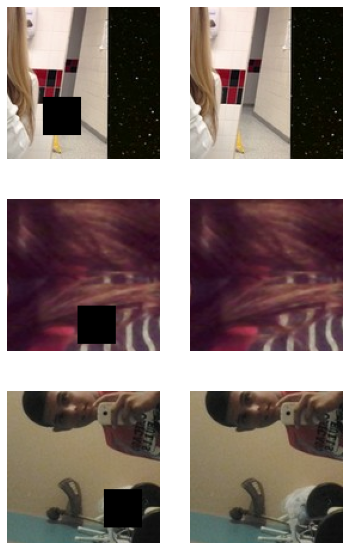

In [16]:
home = os.getenv("HOME")

copies_per_image = 1
images_per_batch = 64
dataset = tf.data.Dataset.list_files(f'{home}/images/*.jpg')
# train/test split
image_count = tf.cast(dataset.cardinality(), tf.float32)
train_perc = tf.constant(0.8)
train_dataset = dataset.take(tf.cast(tf.math.round(image_count * train_perc), tf.int64))
val_dataset = dataset.skip(tf.cast(tf.math.round(image_count * train_perc), tf.int64))
train_dataset = train_dataset.shuffle(buffer_size=1000)
val_dataset = val_dataset.shuffle(buffer_size=1000)
# train several times on each image (augmentations will be different)
# train_dataset = train_dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(copies_per_image),cycle_length=4, block_length=copies_per_image)
# val_dataset = val_dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(copies_per_image),cycle_length=4, block_length=copies_per_image)
# read the images
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).cache()
train_dataset = train_dataset.map(partial(tf.image.convert_image_dtype, dtype=tf.float32))
val_dataset = val_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).cache()
val_dataset = val_dataset.map(partial(tf.image.convert_image_dtype, dtype=tf.float32))

# prepare augmented images. dataset of (augmented image, image), block_length augmentions for each
train_dataset = train_dataset.map(partial(random_crop, size=128), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(partial(box_delete, size=32, l=0.06), num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset = train_dataset.map(partial(add_noise, strength=0), num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset = train_dataset.map(lambda x: (x,x), num_parallel_calls=tf.data.AUTOTUNE) # DEBUG
val_dataset = val_dataset.map(partial(random_crop, size=128), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(partial(box_delete, size=32, l=0.06), num_parallel_calls=tf.data.AUTOTUNE)
# val_dataset = val_dataset.map(partial(add_noise, strength=0), num_parallel_calls=tf.data.AUTOTUNE)
# val_dataset = val_dataset.map(lambda x: (x,x), num_parallel_calls=tf.data.AUTOTUNE) # DEBUG

# visualize
train_dataset.apply(visualize_training)

# flatten the original image ("label") so we can use sample weights
train_dataset = train_dataset.map(partial(flatten_labels), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(partial(flatten_labels), num_parallel_calls=tf.data.AUTOTUNE)
# shuffle and batch
train_dataset = train_dataset.batch(images_per_batch * copies_per_image, drop_remainder=True)
val_dataset   = val_dataset.batch(images_per_batch * copies_per_image, drop_remainder=True)
# prefetch
train_dataset = train_dataset.prefetch(4)
val_dataset = val_dataset.prefetch(4)

print("done dataset preparations")
print(train_dataset)

# AE V1
#bridge_features = [16]
# encoder_filters_list = [ 64, 64, 128, 128, 256, 256]
# decoder_filters_list = [256, 256, 128, 128, 64, 64]
# head_filters_list = [32, 32, 16, 3]
bridge_features = [16, 16, 16, 16]
encoder_filters_list = [128, 64, 32, 32, 32]
skip_connections =     [1 ,  1 , 1,  0,  0]
decoder_filters_list = [32, 32, 32,  64, 128]
head_filters_list = [3]

cp_file = f'{home}/model_cp.h5'
if os.path.exists(cp_file):
    print("found checkpoint, loading")
    model = tf.keras.models.load_model(cp_file, 
                               custom_objects={'ConvBlock': ConvBlock, 'DeConvBlock': DeConvBlock, 
                                               'PadToSize': PadToSize, 'PixelWiseHuber': PixelWiseHuber,
                                               'PaddedConcat': PaddedConcat, 'PaddedAdd': PaddedAdd})
else:
    print("checkpoint not found, compiling model")
    model = get_completion_model(bridge_features, encoder_filters_list, decoder_filters_list, skip_connections,
                                 head_filters_list)
#     model = get_simple_model() # for debugging memory leak and comparison with our model
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.001) # default lr, use reduction strategy below
    model.compile(optimizer=opt, loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

# garbage_collect_cb = GCCallback()
# lr_strategy_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.1, patience=3, verbose=1,
#                                                                 mode="min", min_delta=0.001, cooldown=0, min_lr=0.0000001)
model.summary()
history = model.fit(x=train_dataset, steps_per_epoch=2000, epochs=5, validation_data=val_dataset, validation_steps=5, validation_freq=10,
                        workers=3
                        , callbacks=[
                            MemoryCallback(f'{home}/session/keras_memory.log'),
                            tf.keras.callbacks.ModelCheckpoint(cp_file, verbose=1)]
                   )
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(f'{home}/train_history.png')

visualize results

In [ ]:
vis_val = val_dataset.unbatch().shard(num_shards=100, index=0)
def do_model(x, y, z, model):
    #x, y = inputs
#     y = x
    shape = tf.shape(x)
    x = tf.expand_dims(x, axis=0)
    x = model(x)
    x = tf.reshape(x, shape)
    y = tf.reshape(y, shape)
    return x, y, z
do_my_model = lambda x, y, z: do_model(x, y, z, model)
vis_val = vis_val.map(do_my_model)
print(vis_val)
vis_val.apply(visualize_training)
vis_val.apply(visualize_training)